# Project 1: Raphael Painting Identification





** Project Member: **
                                                
                                                
    - Han Ruijian: Feature representation & model training;
    - Hu Wei: Data preprocessing & model training; 
    - Ye Rougang: Prediction & exploration;
    - Zhao Yuqi: Result visualization & document writting.
    
                                                       2018.Feb.26 @HKUST                                                       

**Summary** 
This project aims to identify Raphael painting from forgeries using CNN model. The model is transferred from the famous CNN architecture ResNet18. The determined paintings are cropped into small patches for training model. The model performed very well in the cross validation period so it is reasonable using this model to distinguish the disputed ones. We also studied the features extracted from the model and visualized the result on the painting.

![avatar](painting_1.png)
_Result visualization of a disputed painting[7], the filled cycle refer to the probability of authenticity of corresponding patch._ 

_The more green, the more possible to be authentic; the more blue, the more possible to be fake_

## Data Set and Problem Description  
The data set consists of 28 digital paintings of Raphael or forgeries. 12 of them are identified as authentic Raphael painting by experts and 10 of them are fake ones. Authenticity of the rest 6 painting are controversial. Each painting has differaent size and different content. But it seems that they are all sketch manuscript. 

The Problem is to identify the authentic paintings from the fake ones. Without expertise of art, it is almost impossible to extract useful features as evidence from painting. In this project, we tried to use CNN model to deal with this issue.

CNN model have been proven as a powerful model to manage computer vision problem. However, training a CNN model for special domain needs mass labelled pictures. In this project, the size of dataset is limited, which means it is unreachable to train a reliable CNN from the beginning. Besides, the theories about CNN model is not such solid, thus we must be careful when using the features extracted by CNN. 

## Methodology 

It is reasonable to assume the textures in different Raphael painting are similar. And we hope that our CNN model can recognize the pattern of these textures and distinguish the textures between the authenitic and the fake. 

To deal with the date shortage problem, we use a technology called 'transfer learning', which means we can set a well-trained model in a different but related domain, to help solving our problem. In this project, we construct our model transferred from the famous CNN model, ResNet18. By replacing the original full connect layer with a new one, the possible output changes from 100 to 2, thus fit our problem. The original parameters in other layers were preserved as initialization. This method would significantly speed up the training proces. 

The paintings were corpped into small patches to feed the model. This is because the texture is believed as strong feature for identifying thus. High resolution patch will remained for lots of information of texture and the global information(such as kind, number of objects) will be thought to provide little information for identifying. (Even through this model was designed to recognize global problem such as classification or detection.)

## Data Preprocessing

We first crop 21 labelled pictures into small pieces for futher processing.
Since we would like to transfer pretrained ResNet18 to our project, we cut pictures into size (224, 224). 
Besides parts of original pictures are blank, we simply remove them by filtering according to variacne of cropped pieces.
After some tests, we choose this threshold value to be 200.

In [1]:
crop_size = (224, 224)
picture_dir = 'Raphael_Project'
disputed_id = [1, 7, 10, 20, 23, 25, 26]
authentic_id = [2, 3, 4, 5, 6, 8, 9, 21, 22, 24, 27, 28]
fake_id = [11, 12 ,13, 14, 15, 16, 17, 18, 19] 
labels = dict(**{str(x):'fake' for x in fake_id}, **{str(x):'disputed' for x in disputed_id}, 
              **{str(x):'authentic' for x in authentic_id})
low_var_filter = True
low_var_threshold = 200

In [2]:
from Crop_Images import crop_Images
crop = crop_Images(picture_dir, labels, low_var_filter, low_var_threshold)

We may either crop pictures randomly or sequentially.

In [3]:
crop.random_crop(crop_size, n_multiple = 2)

folder:  data/train/disputed does not exists, creating
folder:  data/train/authentic does not exists, creating
folder:  data/train/fake does not exists, creating
totally 18072 pictures created 


In [3]:
crop.sequential_crop(crop_size, offset=(180, 180))

Folder: data/train\disputed does not exist, creating
Folder: data/train\authentic does not exist, creating
Folder: data/train\fake does not exist, creating
totally 12034 pictures created, we ignore 1055 low variance pictures


Note that after cropping, we move disputed folder to its parent directory for further testing.

Then, we randomly choose two pictures, one from authentic set, one from fake set, move all its subpictures to validation folder.

In [12]:
crop.shuffle_validation()

take 2 and 15 as validation pictures


Now, we have enough data for training and validating.

## Model training: Transfer learning

In [13]:
from torchvision import datasets, models, transforms
import torch
import os
import torchvision
from training import imshow, train_model, visualize_model
use_gpu = torch.cuda.is_available()

We first train 20 epochs, then randomly horizontally flip data to train another 20 epochs to get our best model.

In [14]:
data_transforms = {
   'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
datasets.folder.IMG_EXTENSIONS.append('tif')
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 8680, 'val': 751}
['authentic', 'fake']


Let's view some images.

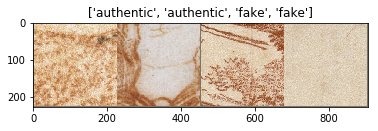

In [16]:
inputs, classes = next(iter(dataloaders['train']))
imshow(torchvision.utils.make_grid(inputs), title=[class_names[x] for x in classes])

Let's borrow pretrained ResNet18 from PyTorch, reset final fully connected layer. 

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 2)
if use_gpu:
    model_ft = model_ft.cuda()

criterion = torch.nn.CrossEntropyLoss()

# Note that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, 
                       dataset_sizes, use_gpu, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.3644 Acc: 0.8672
val Loss: 0.5011 Acc: 0.7736

Epoch 1/19
----------
train Loss: 0.1773 Acc: 0.9477
val Loss: 0.1393 Acc: 0.9507

Epoch 2/19
----------
train Loss: 0.1568 Acc: 0.9533
val Loss: 0.2489 Acc: 0.8695

Epoch 3/19
----------
train Loss: 0.1038 Acc: 0.9643
val Loss: 0.0924 Acc: 0.9747

Epoch 4/19
----------
train Loss: 0.0709 Acc: 0.9771
val Loss: 0.6963 Acc: 0.7683

Epoch 5/19
----------
train Loss: 0.0385 Acc: 0.9872
val Loss: 0.1336 Acc: 0.9441

Epoch 6/19
----------
train Loss: 0.0390 Acc: 0.9870
val Loss: 0.5415 Acc: 0.8123

Epoch 7/19
----------
train Loss: 0.0070 Acc: 0.9982
val Loss: 0.3413 Acc: 0.8455

Epoch 8/19
----------
train Loss: 0.0028 Acc: 0.9999
val Loss: 0.6735 Acc: 0.7830

Epoch 9/19
----------
train Loss: 0.0032 Acc: 0.9994
val Loss: 0.3469 Acc: 0.8655

Epoch 10/19
----------
train Loss: 0.0043 Acc: 0.9987
val Loss: 0.5511 Acc: 0.8043

Epoch 11/19
----------
train Loss: 0.0026 Acc: 0.9994
val Loss: 0.3823 Acc: 0.8535

Ep

Randomly horizontally flip, train another 20 epochs.

In [19]:
data_transforms = {
   'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
datasets.folder.IMG_EXTENSIONS.append('tif')
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, 
                       dataset_sizes, use_gpu, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.0371 Acc: 0.9899
val Loss: 0.1886 Acc: 0.8975

Epoch 1/19
----------
train Loss: 0.0291 Acc: 0.9907
val Loss: 0.1151 Acc: 0.9441

Epoch 2/19
----------
train Loss: 0.0285 Acc: 0.9919
val Loss: 0.0810 Acc: 0.9694

Epoch 3/19
----------
train Loss: 0.0283 Acc: 0.9911
val Loss: 0.0533 Acc: 0.9814

Epoch 4/19
----------
train Loss: 0.0301 Acc: 0.9914
val Loss: 0.0926 Acc: 0.9614

Epoch 5/19
----------
train Loss: 0.0259 Acc: 0.9927
val Loss: 0.0753 Acc: 0.9680

Epoch 6/19
----------
train Loss: 0.0293 Acc: 0.9911
val Loss: 0.0541 Acc: 0.9840

Epoch 7/19
----------
train Loss: 0.0233 Acc: 0.9937
val Loss: 0.0534 Acc: 0.9880

Epoch 8/19
----------
train Loss: 0.0286 Acc: 0.9910
val Loss: 0.0711 Acc: 0.9814

Epoch 9/19
----------
train Loss: 0.0267 Acc: 0.9931
val Loss: 0.1002 Acc: 0.9521

Epoch 10/19
----------
train Loss: 0.0277 Acc: 0.9917
val Loss: 0.0740 Acc: 0.9800

Epoch 11/19
----------
train Loss: 0.0268 Acc: 0.9915
val Loss: 0.1169 Acc: 0.9441

Ep

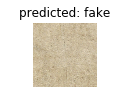

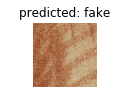

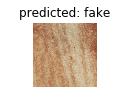

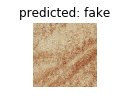

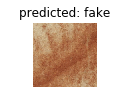

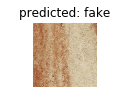

In [21]:
visualize_model(model_ft, dataloaders, class_names, use_gpu)

Finally, let's save our model for future use.

In [22]:
torch.save(model_ft.state_dict(),'modelbest')